# 3.1. MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version = 1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

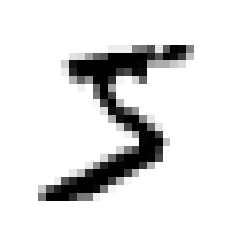

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")

plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np

y = y.astype(np.uint8)

y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [6]:
len(X)

70000

In [7]:
X_train, X_test, y_train, y_test = X[: 60000], X[60000 :], y[: 60000], y[60000 :]

# 3.2. 이진 분류기 훈련

In [8]:
y_train_5 = (y_train == 5)
y_test_5  = (y_test  == 5)

y_train_5

array([ True, False, False, ...,  True, False, False])

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3. 성능 측정
## 3.3.1. 교차 검증

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

for train_idx, valid_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    
    X_valid_fold = X_train[valid_idx]
    y_valid_fold = y_train[valid_idx]
    
    clone_clf.fit(X_train_fold, y_train_fold)
    
    y_pred = clone_clf.predict(X_valid_fold)
    n_correct = sum(y_pred == y_valid_fold)
    
    print(n_correct / len(y_pred))

0.8642
0.87215
0.88795


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

## 3.3.2. 오차 행렬

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

* 행은 실제 클래스, 열은 예측한 클래스
* 첫 번째 행은 음성 클래스, 두 번째 행은 양성 클래스

In [17]:
from copy import copy

y_train_perfect_predictions = copy(y_train_5)

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 정밀도

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred) # 재현율

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred) # F1 점수

0.7325171197343846

In [21]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [26]:
thresholds.shape

(59966,)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[: -1], "g-", label = "Recall")
    
    plt.legend()

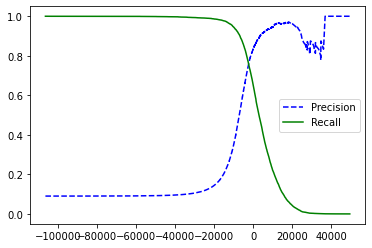

In [28]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

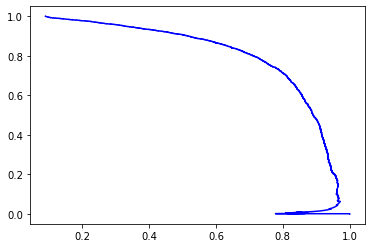

In [29]:
plt.plot(precisions, recalls, "b-")

plt.show()

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= .9)] # 0.9 보다 큰 첫 번째 인덱스 호출

threshold_90_precision

3370.0194991439557

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# 3.4. 다중 분류

In [35]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
some_digit_scores = svm_clf.decision_function([some_digit])

some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [37]:
np.argmax(some_digit_scores)

5

In [38]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [40]:
svm_clf.classes_[5]

5

In [41]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

KeyboardInterrupt: 

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

# 3.6. 다중 레이블 분류

In [42]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd   = (y_train % 2 == 1)
y_multilabel  = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [43]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

# 3.7. 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod  = X_test + noise
X_train_mod = X_train
X_test_mod  = X_test